In [1]:
import calendar
import datetime as dt
import dateutil.parser as dp
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os
import ipympl

from IPython.display import display, Markdown
from functools import partial
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

# Parameters

In [2]:
YEAR_FILTER = '2021'
EXPECTED_PARSERS_PER_FTE = 2.5
INTERACTIVE_CHARTS = False
PARSER_POINT  = {'XL' : 21, 'L' : 13, 'M' : 8, 'S': 5, 'XS' : 3}
START_TEXT_POSITION = {'bottom' : 0, 'top' : 1}

# Notebook Options

In [3]:
if INTERACTIVE_CHARTS:
    %matplotlib widget
else:
    %matplotlib inline

pd.set_option('display.max_rows', None)

# Setting up key, token and Service Account

In [4]:
with open('keys.json') as file:
    keys = json.load(file)
    api_key = keys['trello']['api_key']
    token = keys['trello']['token']
    spreadsheet_key = keys['sheet']['spreadsheet_key']
    sa_file = keys['sheet']['sa_file']

# Extracting Sheet Data

In [5]:
def convert_sheet_date(sheet_date):
    conversion_table = {
        'January': '01',
        'February': '02',
        'March': '03',
        'April': '04',
        'May': '05',
        'June': '06',
        'July': '07',
        'August': '08',
        'September': '09',
        'October': '10',
        'November': '11',
        'December': '12'
    }
    
    month = conversion_table[sheet_date.split('-')[0].strip()]
    year = sheet_date.split('-')[1].strip()
    
    return year + '-' + month

In [6]:
def get_consolidated_sheet():
    scope = ['https://spreadsheets.google.com/feeds']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(sa_file, scope)
    service = build('sheets', 'v4', credentials=credentials)

    SAMPLE_RANGE_NAME = 'Consolidated'
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=spreadsheet_key,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    
    return values

In [7]:
def get_total_row_from_sheet():
    table = get_consolidated_sheet()
    
    header_row = table[0]
    columns = [value for index, value in enumerate(header_row) if value] 
    converted_columns = [ convert_sheet_date(x) for x in columns[1:]]
    
    total_row = [value for value in table if value and value[0] == 'Total'][0]
    
    return total_row, converted_columns

In [8]:
def get_executed_by_date():
    total_row, converted_columns = get_total_row_from_sheet()
    
    # getting only the executed column
    executed = [value for index, value in enumerate(total_row) if index % 3 == 0]

    executed.pop(0)
    
    executed_by_date = [ [converted_columns[index], value] for index, value in enumerate(executed)]
    
    return executed_by_date

In [9]:
def get_planned_by_date():
    total_row, converted_columns = get_total_row_from_sheet()
    
    # getting only the planned column
    planned = [total_row[i] for i in range(2, len(total_row), 3)]

    planned.pop(0)
    
    planned_by_date = [ [converted_columns[index], value] for index, value in enumerate(planned)]
    
    return planned_by_date

In [10]:
def create_ftes_dataframe():
    # from deprecated sheet, it will never be changed
    old_data = [
        ['2020-03', 4.0],
        ['2020-04', 6.15],
        ['2020-05', 6.25],
        ['2020-06', 6.0],
        ['2020-07', 3.65],
        ['2020-08', 4.57],
        ['2020-09', 4.52],
        ['2020-10', 4.9],
        ['2020-11', 4.7]
    ]
    
    #Total fte
    new_executed_data = get_executed_by_date()
    
    full_executed_data = old_data + new_executed_data
    
    executed_fte = pd.DataFrame(full_executed_data, columns=['month_base', 'executed_fte'])
    
    executed_fte['month_base'] = pd.to_datetime(executed_fte['month_base'])
    executed_fte['month'] = pd.PeriodIndex(executed_fte['month_base'], freq='M')
    executed_fte['quarter'] = pd.PeriodIndex(executed_fte['month_base'], freq='Q')
    executed_fte['executed_fte'] = executed_fte['executed_fte'].astype(float)
    
    del executed_fte['month_base']
    
    #Planned fte  
    new_planned_data = get_planned_by_date()
    
    full_planned_data = old_data + new_planned_data
    
    planned_fte = pd.DataFrame(full_planned_data, columns=['month_base', 'planned_fte'])
    
    planned_fte['month_base'] = pd.to_datetime(planned_fte['month_base'])
    planned_fte['month'] = pd.PeriodIndex(planned_fte['month_base'], freq='M')
    planned_fte['planned_fte'] = planned_fte['planned_fte'].astype(float)
    
    del planned_fte['month_base']
    
    #Merge
    total_fte = executed_fte.merge(planned_fte, how='left')
    total_fte = total_fte.reindex(['planned_fte', 'executed_fte', 'month', 'quarter'], axis='columns')
    total_fte.fillna(value=0.00, inplace=True)
    
    return total_fte

In [11]:
total_fte = create_ftes_dataframe()
total_fte

,planned_fte,executed_fte,month,quarter
0,4.00,4.00,2020-03,2020Q1
1,6.15,6.15,2020-04,2020Q2
2,6.25,6.25,2020-05,2020Q2
3,6.00,6.00,2020-06,2020Q2
4,3.65,3.65,2020-07,2020Q3
5,4.57,4.57,2020-08,2020Q3
6,4.52,4.52,2020-09,2020Q3
7,4.90,4.90,2020-10,2020Q4
8,4.70,4.70,2020-11,2020Q4
9,5.65,4.90,2020-12,2020Q4


# Extracting Trello Data

In [12]:
def get_data_from_trello_api(url):
    headers = {
       "Accept": "application/json"
    }
    
    query = {
       'key': api_key,
       'token': token
    }
    
    response = requests.request("GET", url, headers=headers, params=query)
    
    if response.status_code > 299:
        raise Exception('Something went wrong with the request {0} '\
                        'with status: {1}'.format(url, response.status_code))
    
    return json.loads(response.text)

In [13]:
def read_json(json_name):
    with open(json_name) as file:
        json_opened = json.load(file)
           
    return json_opened 

In [14]:
def write_json(json_name, content_to_write):
    with open(json_name, 'w') as json_file:
        json.dump(content_to_write, json_file, indent=4, sort_keys=True)

In [15]:
def generate_timestamp():
    current_timestamp = dt.datetime.now().strftime('%d-%m-%Y')
    
    return current_timestamp

In [16]:
def create_folder_for_dumping(name, current_timestamp):
    if not os.path.exists('dumps'):
        os.mkdir('dumps')
    
    if not os.path.exists('dumps/' + name):
        os.mkdir('dumps/' + name)
    
    if not os.path.exists('dumps/' + name + '/' + current_timestamp):
        os.mkdir('dumps/' + name + '/' + current_timestamp)

In [17]:
def get_data_from_dump(board_name, dump_name, timestamp):
    path = 'dumps/' + board_name + '/' + timestamp + '/dump_' + dump_name + '.json'
    
    file_opened = read_json(path)
    
    return file_opened

# Acessing API

In [18]:
def get_board_by_name(board_name):
    boards_url = f'https://api.trello.com/1/search?query={board_name}'
    board = get_data_from_trello_api(boards_url)
    
    return board

In [19]:
def get_lists_by_board(board_name, board_id, current_timestamp):
    lists_url = 'https://api.trello.com/1/boards/{0}/lists'
    lists = get_data_from_trello_api(lists_url.format(board_id))
          
    return lists

In [20]:
def get_custom_fields_by_board(board_name, board_id, current_timestamp):
    custom_fields_url = 'https://api.trello.com/1/boards/{0}/customFields'
    
    custom_fields = get_data_from_trello_api(custom_fields_url.format(board_id))
    
    return custom_fields

In [21]:
def get_cards_by_board(board_name, board_id, current_timestamp):
    cards_on_board_url = 'https://api.trello.com/1/boards/{0}/cards/?customFieldItems=true'
    board_cards = get_data_from_trello_api(cards_on_board_url.format(board_id))
    
    return board_cards

In [22]:
def get_members_by_board(board_name, board_id, current_timestamp):
    members_on_board_url = 'https://api.trello.com/1/boards/{0}/members'
    board_members = get_data_from_trello_api(members_on_board_url.format(board_id))
    
    return board_members

# Creating dumps

In [23]:
def create_boards_dump(board_name, current_timestamp):
    boards = get_board_by_name(board_name)

    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_board.json'
        
    write_json(name_of_dump, boards)
    
    return name_of_dump

In [24]:
def get_id_board_from_dump(board_name, current_timestamp):
    board = get_board_by_name_from_dump(board_name, current_timestamp)
    id_board = board['boards'][0]['id']

    return id_board

In [25]:
def create_lists_dump(board_name, board_id, current_timestamp):
    lists = get_lists_by_board(board_name, board_id, current_timestamp)
    
    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_lists.json'
    write_json(name_of_dump, lists)
        
    return name_of_dump

In [26]:
def create_custom_fields_dump(board_name, board_id, current_timestamp):
    custom_fields = get_custom_fields_by_board(board_name, board_id, current_timestamp)
        
    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_custom_field.json'
    write_json(name_of_dump, custom_fields)
        
    return name_of_dump

In [27]:
def create_cards_dump(board_name, board_id, current_timestamp):
    board_cards = get_cards_by_board(board_name, board_id, current_timestamp)    
       
    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_cards.json'
    
    write_json(name_of_dump, board_cards)
            
    return name_of_dump

In [28]:
def create_members_dump(board_name, board_id, current_timestamp):
    board_members = get_members_by_board(board_name, board_id, current_timestamp)    
       
    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_members.json'
    
    write_json(name_of_dump, board_members)
            
    return name_of_dump

In [29]:
def create_dumps_by_name(board_name, current_timestamp):
    create_folder_for_dumping(board_name, current_timestamp)
    
    create_boards_dump(board_name, current_timestamp)
    
    board_id = get_id_board_from_dump(board_name, current_timestamp)
    
    create_lists_dump(board_name, board_id, current_timestamp)
    create_custom_fields_dump(board_name, board_id, current_timestamp)
    create_cards_dump(board_name, board_id, current_timestamp)
    create_members_dump(board_name, board_id, current_timestamp)

# Getting data from dumps

In [30]:
def get_board_by_name_from_dump(board_name, timestamp):
    board = get_data_from_dump(board_name, 'board', timestamp)
    
    return board

In [31]:
def mapping_lists_by_board_from_dump(board_name, timestamp):
    lists_json = get_data_from_dump(board_name, 'lists', timestamp)
    
    list_map = {}
    for list in lists_json:
        list_map[list['id']] = list['name']
    
    return list_map

In [32]:
def mapping_custom_fields_by_board_from_dump(board_name, timestamp):
    custom_fields_json = get_data_from_dump(board_name, 'custom_field', timestamp)
    
    custom_field_map = {}
    for custom_field in custom_fields_json:
        custom_field_map[custom_field['id']] = custom_field['name']
        
        if custom_field['type'] == 'list':
            options = custom_field['options']
            for option in options:
                custom_field_map[option['id']] = option['value']['text']
    
    return custom_field_map

In [33]:
def mapping_members_by_board_from_dump(board_name, timestamp):
    members_json = get_data_from_dump(board_name, 'members', timestamp)
    
    members_map = {}
    for member in members_json:
        members_map[member['id']] = member['fullName']
    
    return members_map

In [34]:
def transforming_member_list_to_str(members_in_card_list):
    members_list_sorted = sorted(members_in_card_list)
    members_str = ' and '.join(members_list_sorted)
    return members_str

In [35]:
def create_normalized_card(card, lists_map, members_map, custom_fields_map, custom_field_required):
    normalized_card = {}
    normalized_card['name'] = card['name']
    normalized_card['shortUrl'] = card['shortUrl']
    normalized_card['idList'] = lists_map[card['idList']]

    members_in_card_list = []
    for member in card['idMembers']:
        members_in_card_list.append(str.lower(members_map[member]))
    members_in_card_str = transforming_member_list_to_str(members_in_card_list)
    normalized_card['Members'] = members_in_card_str

    for custom_field in card['customFieldItems']:
        name = custom_fields_map[custom_field['idCustomField']]

        if name in custom_field_required:

            if 'idValue' in custom_field:
                name_value = custom_fields_map[custom_field['idValue']]
                normalized_card[name] = name_value
                
                if name_value in PARSER_POINT:
                    normalized_card['parser_points'] = PARSER_POINT[name_value]

            elif 'value' in custom_field:
                for key, value in custom_field['value'].items():
                    result = value 
                normalized_card[name] = result
        
    if len(normalized_card) < 3:
        raise Exception(
            'Make sure all dates are filled in the card: Start, EndDev and End for {0}'.format(card['name']))
    
    return normalized_card

In [36]:
def get_useful_cards_by_board(board_name, timestamp):
    cards_raw = get_data_from_dump(board_name, 'cards' , timestamp)
        
    fields = ('id', 'name', 'idList', 'shortUrl', 'customFieldItems', 'idMembers')

    cards = [{key : value for key, value in card.items() if key in fields} for card in cards_raw ]

    custom_fields_map = mapping_custom_fields_by_board_from_dump(board_name, timestamp)

    lists_map = mapping_lists_by_board_from_dump(board_name, timestamp)

    members_map = mapping_members_by_board_from_dump(board_name, timestamp)
    
    custom_field_required = read_json('custom_fields_required.json')

    useful_cards = []
    for card in cards:
        
        idListName = lists_map[card['idList']]
        
        if idListName in ['Done']:
            normalized_card = create_normalized_card(card, lists_map, members_map, custom_fields_map, custom_field_required)
            useful_cards.append(normalized_card)
            
    return useful_cards

In [37]:
def create_dataframe_from_trello(board_name, timestamp):
    cards = get_useful_cards_by_board(board_name, timestamp)
    df = pd.DataFrame.from_dict(cards)

    df['dev_duration'] = (pd.to_datetime(df['EndDev']).dt.date - pd.to_datetime(df['Start']).dt.date).dt.days
    df['duration'] = (pd.to_datetime(df['End']).dt.date - pd.to_datetime(df['Start']).dt.date).dt.days
    
    df['busday_dev_duration'] = np.busday_count(
        pd.to_datetime(df['Start']).dt.date,
        pd.to_datetime(df['EndDev']).dt.date)
    
    df['busday_duration'] = np.busday_count(
        pd.to_datetime(df['Start']).dt.date,
        pd.to_datetime(df['End']).dt.date)
    
    df['quarter'] = pd.PeriodIndex(df['End'], freq='Q')
    
    df['month'] = pd.PeriodIndex(df['End'], freq='M')

    df['count'] = 1
    
    return df

In [38]:
current_timestamp = generate_timestamp()
create_dumps_by_name('CBN', current_timestamp)
df = create_dataframe_from_trello('CBN', current_timestamp)

# Filter only items from defined year - by End date.
if YEAR_FILTER:
    df = df[df['End'].str.contains(YEAR_FILTER)]

In [39]:
df

,name,shortUrl,idList,Members,Commit Date (by Google),Date requested (by Google),Impacted parsers,New parser,Size/Complexity,parser_points,...,Priority,End,Start,dev_duration,duration,busday_dev_duration,busday_duration,quarter,month,count
0,GCP_CLOUDAUDIT_b197038246,https://trello.com/c/P4E1B5C6,Done,diegogr_cit,2021-07-31T15:00:00.000Z,2021-06-28T15:00:00.000Z,Default,No,XS,3.0,...,P1,2021-08-26T17:49:48.000Z,2021-08-18T21:33:00.000Z,1,8,1,6,2021Q3,2021-08,1
1,WINEVTLOG,https://trello.com/c/lGidlGym,Done,atos_cit and diegogr_cit,2021-08-13T15:00:00.000Z,2021-08-08T15:00:00.000Z,Default and Customer,No,S,5.0,...,P2,2021-08-26T15:40:00.000Z,2021-08-20T14:45:56.000Z,5,6,3,4,2021Q3,2021-08,1
2,GCP_BIGQUERY_CONTEXT,https://trello.com/c/6AFvTi4U,Done,diegogr_cit,2021-08-29T15:00:00.000Z,2021-08-09T15:00:00.000Z,Default,Yes,XS,3.0,...,P2,2021-08-25T14:30:34.000Z,2021-08-17T15:01:00.000Z,1,8,1,6,2021Q3,2021-08,1
3,WORKSPACE_ACTIVITY,https://trello.com/c/IIFpxgMF,Done,felipegc_cit,2021-08-01T20:09:00.000Z,2021-07-16T20:09:00.000Z,Default,Yes,L,13.0,...,P2,2021-08-25T13:54:06.000Z,2021-08-04T18:07:16.000Z,19,21,13,15,2021Q3,2021-08,1
4,CBN - GCP Security Center (include nampespace),https://trello.com/c/ILOE5BES,Done,felipegc_cit,2021-08-20T15:00:00.000Z,2021-06-24T15:45:00.000Z,Default,No,XS,3.0,...,P2,2021-08-24T13:40:58.000Z,2021-08-17T22:11:55.000Z,1,7,1,5,2021Q3,2021-08,1
5,BLUECOAT_WEBPROXY,https://trello.com/c/gt4NyMtb,Done,diego de oliveira maranhao and felipegc_cit,2021-07-22T15:00:00.000Z,2021-06-15T15:00:00.000Z,Default,No,M,8.0,...,P2,2021-08-23T21:47:30.000Z,2021-07-28T15:21:53.000Z,20,26,14,18,2021Q3,2021-08,1
6,WORKSPACE_ALERTS,https://trello.com/c/wrHwWqku,Done,davisom da cunha correa and felipegc_cit and f...,2021-08-01T15:00:00.000Z,2021-07-16T15:00:00.000Z,Default,Yes,L,13.0,...,P2,2021-08-23T13:51:39.000Z,2021-08-11T13:17:49.000Z,8,12,6,8,2021Q3,2021-08,1
7,CISCO_IOS,https://trello.com/c/RKgW7vrG,Done,atos_cit and felipegc_cit,2021-08-07T15:00:00.000Z,2021-06-29T15:00:00.000Z,Default,Yes,S,5.0,...,P2,2021-08-23T13:49:14.000Z,2021-08-17T14:36:21.000Z,3,6,3,4,2021Q3,2021-08,1
8,GCP_CLOUDAUDIT_b192934169_CreateCryptoKey,https://trello.com/c/SGVdVMM7,Done,atos_cit and diegogr_cit,2021-07-18T15:00:00.000Z,2021-07-06T15:00:00.000Z,Default,No,XS,3.0,...,P2,2021-08-18T21:16:54.000Z,2021-08-16T19:14:57.000Z,0,2,0,2,2021Q3,2021-08,1
9,GCP_CLOUDAUDIT_b192933604_ SetIamPolicy,https://trello.com/c/qLpcGw4l,Done,atos_cit and diegogr_cit,2021-07-18T15:00:00.000Z,2021-07-06T15:00:00.000Z,Default,No,XS,3.0,...,NaN,2021-08-18T21:16:52.000Z,2021-08-09T12:49:32.000Z,7,9,5,7,2021Q3,2021-08,1


In [40]:
cancelled = df[(df['idList'] == 'Cancelled')]
done = df[(df['idList'] == 'Done')]

# Calculating General Estimatives

In [41]:
def mapping_start_text_position(start_text_position_string):
    if start_text_position_string in START_TEXT_POSITION.keys():
        return START_TEXT_POSITION[start_text_position_string]
    else:
        raise Exception(f'"{start_text_position_string}" is not defined. Must be "bottom" or "top".')

In [42]:
def text_position(next_position):
    position = ['bottom','top']
    return position[next_position % 2]

In [43]:
def get_extremes(data_frame, duration_column):
    upper_q = partial(pd.Series.quantile, q=0.95)
    lower_q = partial(pd.Series.quantile, q=0.05)

    upper_extremes = data_frame[duration_column].agg([upper_q])["quantile"]
    lower_extremes = data_frame[duration_column].agg([lower_q])["quantile"]
    
    return lower_extremes, upper_extremes

In [44]:
def calculate_estimatives_by_duration_column(data_frame, duration_column, print_results=True):
    lower_extremes, upper_extremes = get_extremes(data_frame, duration_column)
    
    done_extremes_removed = data_frame[(data_frame[duration_column] > lower_extremes) & (data_frame[duration_column] < upper_extremes)]
    mean_removed_extremes = done_extremes_removed[duration_column].mean()
    
    small_q = partial(pd.Series.quantile, q=0.25)
    small_limit = done_extremes_removed[duration_column].agg([small_q])["quantile"]
    
    small_extremes_removed = done_extremes_removed[(done_extremes_removed[duration_column] <= small_limit)]
    not_small_extremes_removed = done_extremes_removed[(done_extremes_removed[duration_column] > small_limit)]
    
    mean_small_extremes_removed = small_extremes_removed[duration_column].mean()
    mean_not_small_extremes_removed = not_small_extremes_removed[duration_column].mean()
    
    total_developed = len(data_frame)
    
    if print_results:
        features = ('lower_extremes', 'upper_extremes', 'small limit', 'Done estimate (with "extremes" removed)',
                   'Done estimate for "Small" ones', 'Done estimate for "Big" ones', 'Total_developed')
        values = (lower_extremes, upper_extremes, small_limit, mean_removed_extremes, mean_small_extremes_removed, 
                 mean_not_small_extremes_removed, total_developed)
        general_estimatives = {'Feature':features, 'Value':values}
        general_estimatives_df = pd.DataFrame(data=general_estimatives)
        display(general_estimatives_df)
    
    return done_extremes_removed

In [45]:
def calculate_estimatives(data_frame):
    display(Markdown('### Total Duration:'))
    calculate_estimatives_by_duration_column(data_frame, 'duration')
    print('\n')
    display(Markdown('### Total Dev Duration:'))
    calculate_estimatives_by_duration_column(data_frame, 'dev_duration')
    print('\n')
    display(Markdown('## BUSINESS DAY'))
    print('\n')
    display(Markdown('### Business Day Duration:'))
    calculate_estimatives_by_duration_column(data_frame, 'busday_duration')
    print('\n')
    display(Markdown('### Business Day Dev Duration:'))
    calculate_estimatives_by_duration_column(data_frame, 'busday_dev_duration')

In [46]:
def generate_table_amount_delivered_by_period(df, total_fte, period): # quarter or month
    by_period = df[[period, 'count']].groupby(period).sum('count')
    by_period_fte = pd.merge(by_period, total_fte, on=period, how='left')
    
    period_result = by_period_fte[[period, 'count','executed_fte']].groupby([period,'count']).sum('executed_fte')
    period_result.reset_index(drop=False, inplace=True)
    
    period_result['parsers_per_fte'] = period_result['count'].div(period_result['executed_fte'])
    
    period_result['target_count'] = period_result['executed_fte'].multiply(EXPECTED_PARSERS_PER_FTE)
    period_result['target_diff'] = period_result['count'].subtract(period_result['target_count'])

    period_result[period] = period_result[period].astype(str)

    return period_result

In [47]:
def generate_chart_amount_delivered_by_period(df, period):
    display(df)
    
    if period == 'month':
        bbox_anchor = 1.01
        start_text_position  = 'bottom'
    else:
        bbox_anchor = 1.21
        start_text_position = 'bottom'
    
    ax = df[[period,'executed_fte', 'parsers_per_fte', 'target_count']].plot(
        x=period,linestyle='-', marker='o', color=['orange', 'pink', 'cyan'])
    
    df[[period,'count']].plot(x=period, kind='bar', ax=ax, figsize=(10,6))
    
    plt.legend(bbox_to_anchor=(bbox_anchor, 1.0))
    
    text_position_count = mapping_start_text_position(start_text_position)
    columns = ['count', 'executed_fte', 'parsers_per_fte', 'target_count']
    for col in columns:
        y = tuple(round(df.groupby(period).sum(col)[col], 3))
        for i in range(len(y)):
            plt.text(x=i, y=y[i], s=str(y[i]), ha='center', va=text_position(text_position_count))
        text_position_count = text_position_count + 1    

In [48]:
def generate_chart_and_table_amount_delivered_by_period(df, total_fte, period):
    if period in ('month', 'quarter'):
        period_result = generate_table_amount_delivered_by_period(df, total_fte, period)
        generate_chart_amount_delivered_by_period(period_result, period)
    
    else:
        raise Exception(f'"{period}" is not defined. Must be "month" or "quarter".')

In [49]:
def generate_table_parser_points_delivered_by_period(df, total_fte, period):
    by_period = df[[period, 'parser_points']].groupby(period).sum('parser_points')
    by_period_fte = pd.merge(by_period, total_fte, on=period, how='left')
    
    period_result = by_period_fte[[period, 'parser_points','executed_fte']].groupby([period,'parser_points']).sum('executed_fte')
    period_result.reset_index(drop=False, inplace=True)
    
    period_result['points_per_fte'] = period_result['parser_points'].div(period_result['executed_fte'])
    
    period_result[period] = period_result[period].astype(str)

    return period_result

In [69]:
def generate_chart_parser_points_delivered_by_period(df, period):
    display(df)
    
    if period == 'month':
        columns = ['parser_points', 'executed_fte', 'points_per_fte']
        bbox_anchor = 1.01
        start_text_position  = 'bottom'
        y_step = 10
        max_y_value = max(df['parser_points'])
    else:
        columns = ['parser_points','points_per_fte', 'executed_fte']
        bbox_anchor = 1.21
        start_text_position = 'bottom'
        y_step = 25
        max_y_value = max(df['parser_points'])
        
    ax = df[[period,'executed_fte', 'points_per_fte']].plot(x = period, linestyle = '-', marker = 'o', 
                                                            color = ['orange', 'pink', 'cyan'])
    df[[period,'parser_points']].plot(x=period, kind='bar', ax=ax, figsize=(10,6))
    plt.legend(bbox_to_anchor=(bbox_anchor, 1.0))
    #plt.yticks(np.arange(0, max_y_value, y_step))
    text_position_count = mapping_start_text_position(start_text_position)
    
    for col in columns:
        y = tuple(round(df.groupby(period).sum(col)[col], 3))
        for i in range(len(y)):
            plt.text(x=i, y=y[i], s=str(y[i]), ha='center', va= text_position(text_position_count)) 
        text_position_count = text_position_count + 1     

In [51]:
def generate_chart_and_table_parser_points_delivered_by_period(df, total_fte, period):
    if period in ('month', 'quarter'):
        period_result = generate_table_parser_points_delivered_by_period(df, total_fte, period)
        generate_chart_parser_points_delivered_by_period(period_result, period)
    
    else:
        raise Exception(f'"{period}" is not defined. Must be "month" or "quarter".')

In [52]:
def generate_table_amount_delivered_by_period_and_size_complexity(df, period): # quarter or month
    period_result = df.groupby([period, 'Size/Complexity']).size().unstack()
    period_result.fillna(value=0, inplace=True)
    return period_result

In [53]:
def generate_chart_amount_delivered_by_period_and_size_complexity(df, period):
    display(df)
    df.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f'Parsers delivered by {period} and Size/Complexity')
    plt.legend(bbox_to_anchor=(1.01, 1.0))
    y = tuple(df.sum(axis=1))
    for i in range(len(y)):
        plt.text(x=i, y=y[i], s=str(y[i]), ha='center', va='bottom')

In [54]:
def generate_chart_and_table_amount_delivered_by_period_and_size_complexity(df, period):
    if period in ('month', 'quarter'):
        period_result = generate_table_amount_delivered_by_period_and_size_complexity(df, period)
        generate_chart_amount_delivered_by_period_and_size_complexity(period_result, period)
    else:
        raise Exception(f'"{period}" is not defined. Must be "month" or "quarter".')

In [55]:
def generate_table_total_delivered_by_members_and_size(df):
    total_by_members = df[['Members', 'count', 'Size/Complexity']].groupby(['Members', 'Size/Complexity']).size(
        ).unstack()
    total_by_members.fillna(value=0.0, inplace=True)
    return total_by_members

In [56]:
def generate_table_total_delivered_by_members(df):
    total_by_members = df[['Members', 'count']].groupby(['Members']).sum('count')
    return total_by_members

In [57]:
def generate_chart_total_delivered_by_members_and_size(df, is_stacked):
    display(df)
    df.plot(kind = 'bar', stacked = is_stacked, figsize=(20,12))
    
    plt.xticks(size=10)
    plt.legend(bbox_to_anchor=(1.075, 1.0))
    y = tuple(df.sum(axis=1))
    for i in range(len(y)):
        plt.text(x=i, y=y[i], s=str(y[i]), ha='center', va='bottom')

In [58]:
def generate_chart_and_table_total_delivered_by_members_and_size(df):
    display(Markdown('### Graph and Table of parsers delivered by members and Size/Complexity'))
    total_by_members_and_size = generate_table_total_delivered_by_members_and_size(df)
    generate_chart_total_delivered_by_members_and_size(total_by_members_and_size, True)
    print('\n')

In [59]:
def generate_chart_and_table_total_delivered_by_members(df):
    display(Markdown('### Graph and Table of parsers delivered by members'))
    total_by_members = generate_table_total_delivered_by_members(df)
    generate_chart_total_delivered_by_members_and_size(total_by_members, False)
    print('\n')

# General Estimatives

In [60]:
calculate_estimatives(done)

### Total Duration:

,Feature,Value
0,lower_extremes,1.000000
1,upper_extremes,62.000000
2,small limit,9.000000
3,"Done estimate (with ""extremes"" removed)",18.845070
4,"Done estimate for ""Small"" ones",6.454545
5,"Done estimate for ""Big"" ones",24.408163
6,Total_developed,81.000000


### Total Dev Duration:

,Feature,Value
0,lower_extremes,0.000000
1,upper_extremes,43.000000
2,small limit,5.000000
3,"Done estimate (with ""extremes"" removed)",12.971831
4,"Done estimate for ""Small"" ones",2.857143
5,"Done estimate for ""Big"" ones",17.220000
6,Total_developed,81.000000


## BUSINESS DAY

### Business Day Duration:

,Feature,Value
0,lower_extremes,1.000000
1,upper_extremes,44.000000
2,small limit,7.000000
3,"Done estimate (with ""extremes"" removed)",13.436620
4,"Done estimate for ""Small"" ones",4.727273
5,"Done estimate for ""Big"" ones",17.346939
6,Total_developed,81.000000


### Business Day Dev Duration:

,Feature,Value
0,lower_extremes,0.000000
1,upper_extremes,31.000000
2,small limit,3.000000
3,"Done estimate (with ""extremes"" removed)",9.281690
4,"Done estimate for ""Small"" ones",2.095238
5,"Done estimate for ""Big"" ones",12.300000
6,Total_developed,81.000000


# Amount delivered by month

,month,count,executed_fte,parsers_per_fte,target_count,target_diff
0,2021-01,4,6.10,0.655738,15.250,-11.250
1,2021-02,11,5.65,1.946903,14.125,-3.125
2,2021-03,10,6.05,1.652893,15.125,-5.125
3,2021-04,12,6.40,1.875000,16.000,-4.000
4,2021-05,8,5.29,1.512287,13.225,-5.225
5,2021-06,10,4.96,2.016129,12.400,-2.400
6,2021-07,9,6.27,1.435407,15.675,-6.675
7,2021-08,17,6.50,2.615385,16.250,0.750


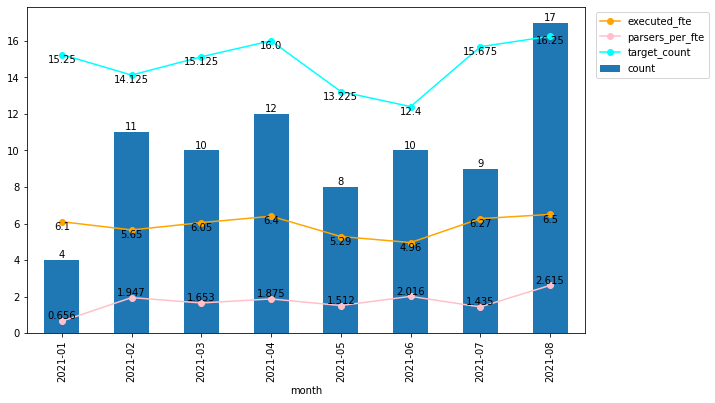

In [61]:
generate_chart_and_table_amount_delivered_by_period(df, total_fte, 'month')

# Amount delivered by quarter

,quarter,count,executed_fte,parsers_per_fte,target_count,target_diff
0,2021Q1,25,17.80,1.404494,44.500,-19.500
1,2021Q2,30,16.65,1.801802,41.625,-11.625
2,2021Q3,26,13.63,1.907557,34.075,-8.075


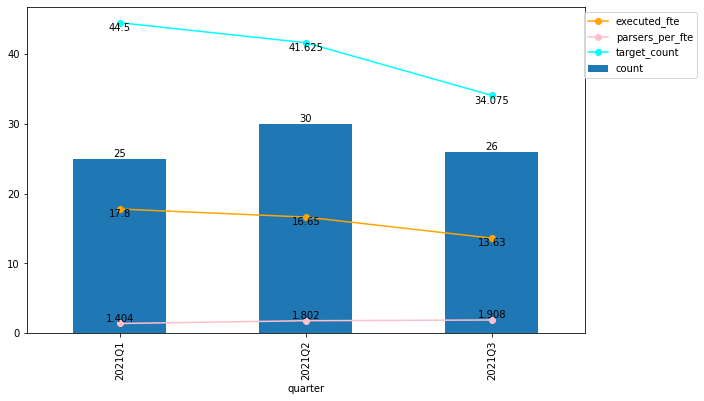

In [62]:
generate_chart_and_table_amount_delivered_by_period(df, total_fte, 'quarter')

# Parser points delivered by month

,month,parser_points,executed_fte,points_per_fte
0,2021-01,32.0,6.10,5.245902
1,2021-02,123.0,5.65,21.769912
2,2021-03,71.0,6.05,11.735537
3,2021-04,80.0,6.40,12.500000
4,2021-05,41.0,5.29,7.750473
5,2021-06,66.0,4.96,13.306452
6,2021-07,41.0,6.27,6.539075
7,2021-08,127.0,6.50,19.538462


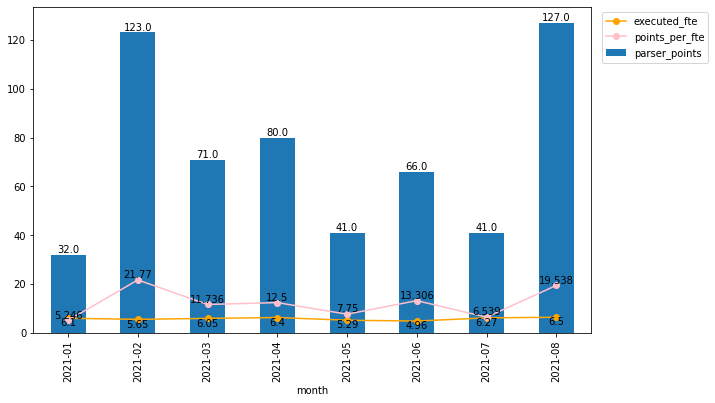

In [70]:
generate_chart_and_table_parser_points_delivered_by_period(df, total_fte, 'month')

# Parser points delivered by quarter

,quarter,parser_points,executed_fte,points_per_fte
0,2021Q1,226.0,17.80,12.696629
1,2021Q2,187.0,16.65,11.231231
2,2021Q3,168.0,13.63,12.325752


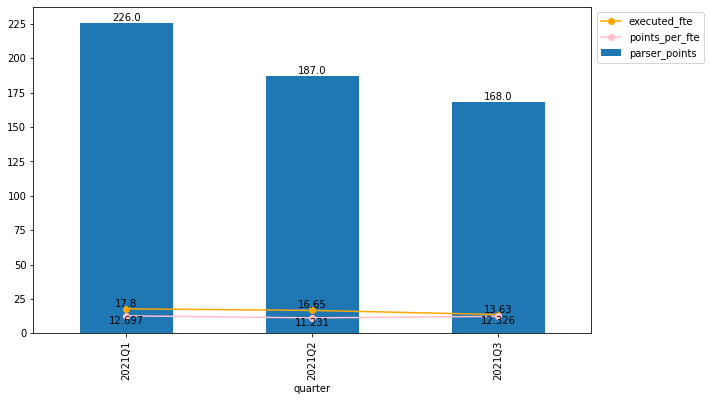

In [64]:
generate_chart_and_table_parser_points_delivered_by_period(df, total_fte, 'quarter')

# Amount delivered by month and Size/Complexity

Size/Complexity,L,M,S,XL,XS
month,,,,,
2021-01,2.0,0.0,0.0,0.0,2.0
2021-02,2.0,2.0,3.0,3.0,1.0
2021-03,0.0,3.0,4.0,1.0,2.0
2021-04,0.0,2.0,8.0,1.0,1.0
2021-05,0.0,3.0,1.0,0.0,4.0
2021-06,2.0,2.0,3.0,0.0,3.0
2021-07,0.0,2.0,2.0,0.0,5.0
2021-08,4.0,2.0,4.0,1.0,6.0


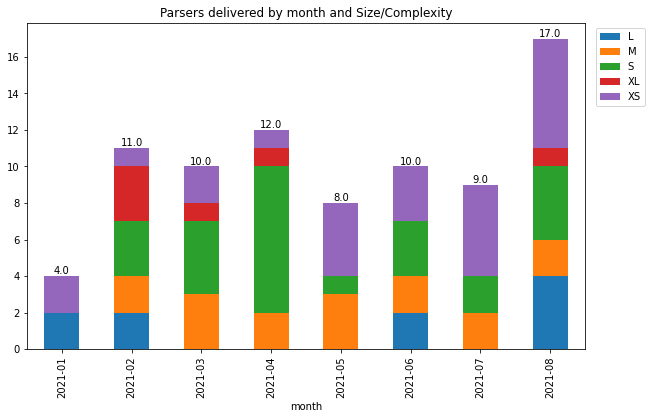

In [65]:
generate_chart_and_table_amount_delivered_by_period_and_size_complexity(df, 'month')

# Amount delivered by quarter and Size/Complexity

Size/Complexity,L,M,S,XL,XS
quarter,,,,,
2021Q1,4,5,7,4,5
2021Q2,2,7,12,1,8
2021Q3,4,4,6,1,11


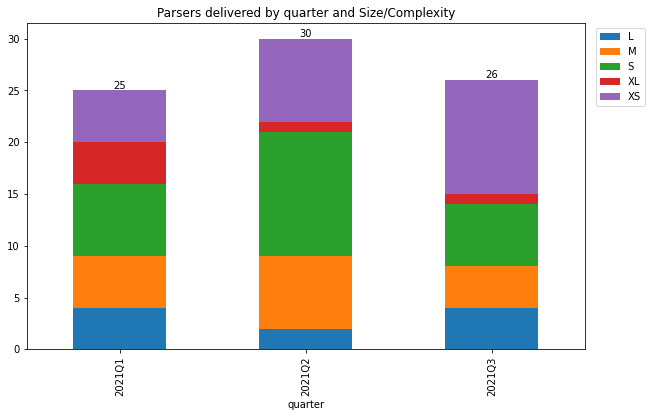

In [66]:
generate_chart_and_table_amount_delivered_by_period_and_size_complexity(df, 'quarter')

# Total delivered by Members

### Graph and Table of parsers delivered by members and Size/Complexity

Size/Complexity,L,M,S,XL,XS
Members,,,,,
atos_cit and diegogr_cit,0.0,1.0,5.0,0.0,3.0
atos_cit and diegogr_cit and felipegc_cit,0.0,0.0,0.0,1.0,0.0
atos_cit and felipegc_cit,0.0,1.0,2.0,0.0,1.0
atos_cit and felipegc_cit and kieras,0.0,0.0,1.0,1.0,0.0
atos_cit and kieras,0.0,0.0,1.0,1.0,0.0
davisom da cunha correa and felipegc_cit and fmendonca_cit,1.0,0.0,0.0,0.0,0.0
diego de oliveira maranhao and diegogr_cit,0.0,1.0,0.0,0.0,3.0
diego de oliveira maranhao and diegogr_cit and felipegc_cit,0.0,1.0,0.0,0.0,0.0
diego de oliveira maranhao and felipegc_cit,1.0,1.0,2.0,0.0,2.0


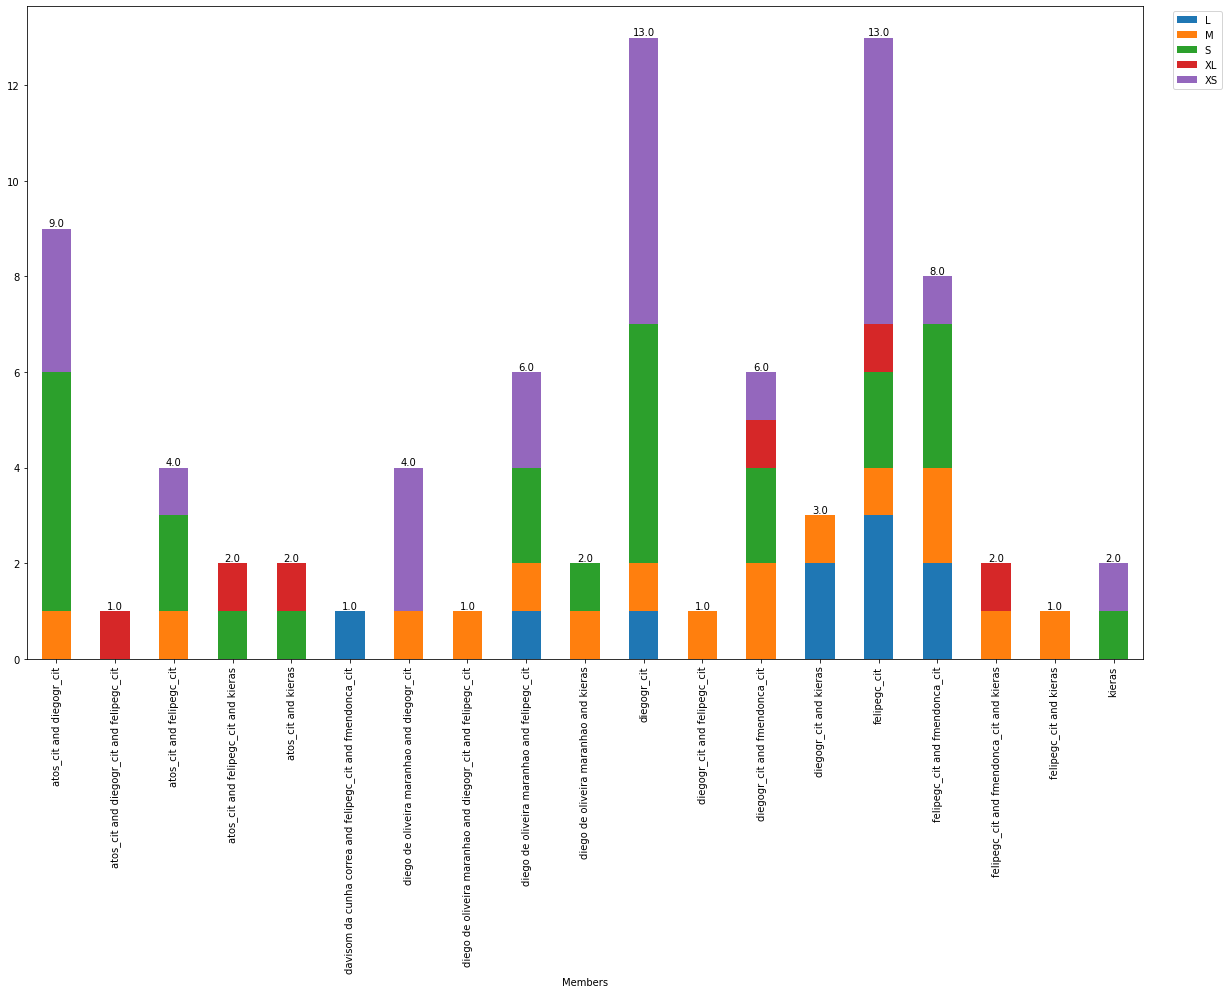

In [67]:
generate_chart_and_table_total_delivered_by_members_and_size(df)

### Graph and Table of parsers delivered by members

,count
Members,
atos_cit and diegogr_cit,9
atos_cit and diegogr_cit and felipegc_cit,1
atos_cit and felipegc_cit,4
atos_cit and felipegc_cit and kieras,2
atos_cit and kieras,2
davisom da cunha correa and felipegc_cit and fmendonca_cit,1
diego de oliveira maranhao and diegogr_cit,4
diego de oliveira maranhao and diegogr_cit and felipegc_cit,1
diego de oliveira maranhao and felipegc_cit,6


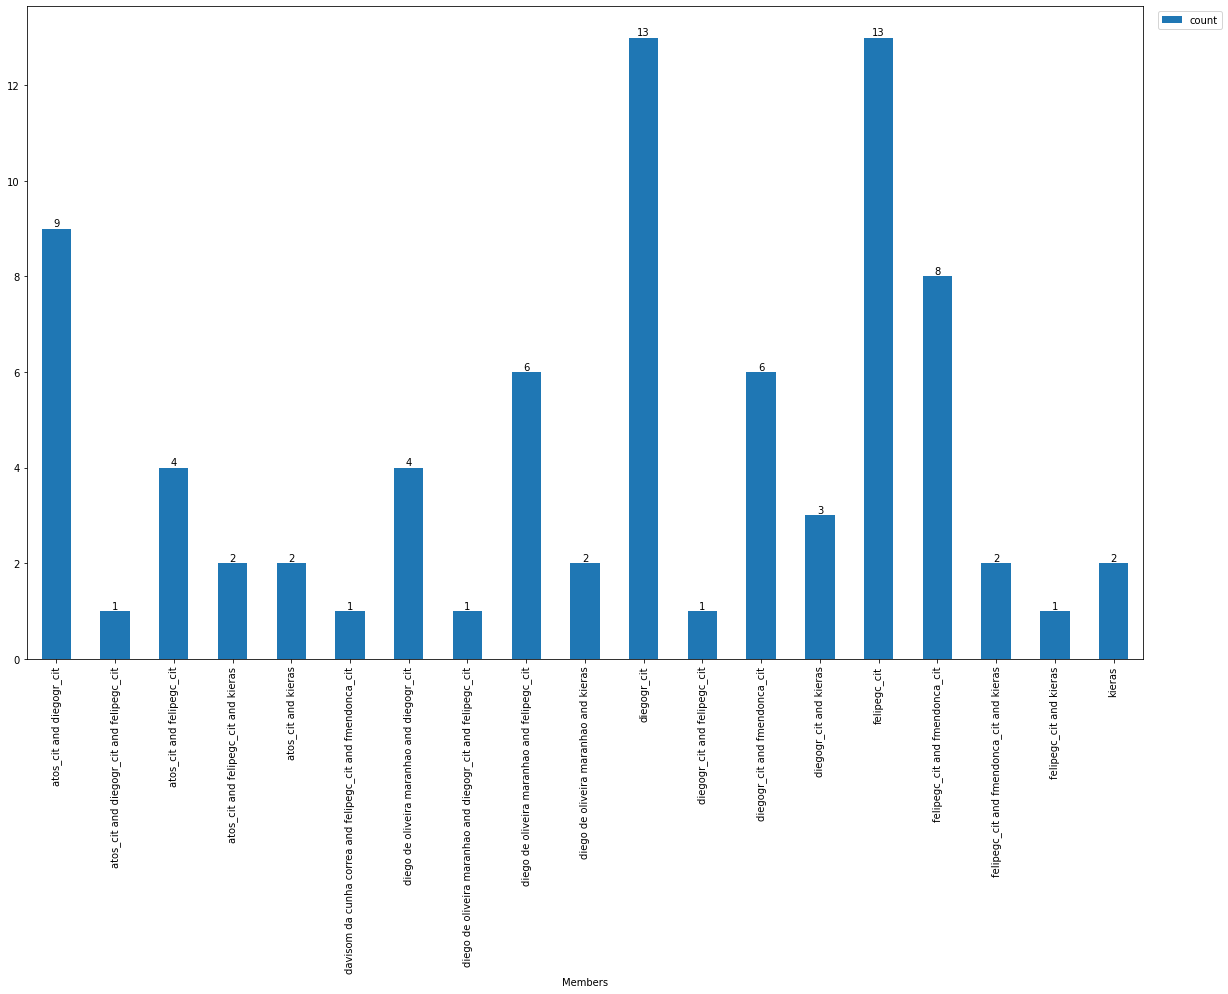

In [68]:
generate_chart_and_table_total_delivered_by_members(df)